# Code description of Momentum Strategy with benchmark.

The aim of this notebook is to describe the code of the momentum strategy implemented by the book __Trading Evolved__ in chapter 12.

Recall that the usual zipline backtesting implementation requires the definition of 3 functions:
- __initialize__
- __handle_data__
- __analyze__

A variation of this implementation is done when implementing the momentum strategy, since we assume we only trade at the end of each month. For this, we define the function __rebalance__, which will replace __handle_data__. 

We then make use of a particular function provided by the zipline API : __schedule_function__. It will help us call the __rebalance__ function at the beginning of each month.

We make emphasis on adding a benchmark to the strategy. For that we define the __benchmark_symbol__ on the model settings (__Section 3__).  We use AAPL as the benchmark just to illustrate the idea. Normally an index describing the overall trend of the stocks involved would be used. In this case in particular, we would use the S&P500 index if data were available.

Once the benchmark has been chosen, we just have to set it on the __initialize__ function.

***

## Content

- Section 0 : the strategy
- Section 1 : libraries
- Section 2 : helper functions and model settings
- Section 3 : main functions (__initialize__, __rebalance__, __analyze__)
- Section 4 : running backtest
- Section 5 : Pyfolio tear sheet

***

## Section 0 : the strategy

The trading strategy we want to backtest follows this rules : 
- Trading is only done monthly : we rebalance at the beginning of each month.
- Only stocks in the S&P500 are considered. Due to data availability for the analysis we consider only the stock that was part of the index as for 2019-01-11 will be considered.
- Momentum slope will be calculated using 125 days.
- Top 30 stocks on momentum slope will be selected.
- Weights will be calculated for these 30 stocks according to inverse volatility.
- Volatility is calculated using 20 day standard deviation.
- Minimum required momentum value is set to 40.
- For each of the 30 selected stocks, if the stock has a momentum value higher than 40, we buy. If not, calculated weight for that stock stays in cash.
- We sell stocks if they fall below the minimum required momentum value, or if they leave the index.

***

## Section 1 : libraries

In [1]:
'''
Zipline dependencies
'''
import zipline
from zipline.api import order_target_percent, symbol,  \
    set_commission, set_slippage, schedule_function, \
    date_rules, time_rules, set_benchmark
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

'''
Pyfolio dependency
'''
import pyfolio as pf

'''
Other dependencies
'''
%matplotlib inline
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
from scipy import stats

***

## Section 2 : helper functions and model settings

Let us first define the model general settings. It is important to notice that we enable comission and slippage to the backtest in order to obtain more realistic results. In order for the backtest to be run properly we require data (i.e. the order book) that allows us to carry the slippage operations.

In [2]:
"""
Model Settings
"""
intial_portfolio = 10000000
momentum_window = 125
minimum_momentum = 40
portfolio_size = 30
vola_window = 20
benchmark_symbol = 'AAPL'

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True 
slippage_volume_limit = 0.25
slippage_impact = 0.1

Below we define the helper functions. We start with the momentum score.

### Momentum score

For the momentum score we first implement an exponential regression on the daily price data for a total of __momentum_window__ days. We obtain the __slope__ and the __intercept__ of the exponential regression: 

$$ y = \text{intercept} * \text{slope}^x$$

The slope of the regression represents the daily percentage change of the stock price estimated by the exponential regression (in fact, this is the reason this method uses an exponential regression). 

Of course the slope alone is not a good proxy of the daily change of price, since the price dynamics might not follow an exponential growth in the current time window. For this reason, to obtain the momentum __score__ we multiply the __slope__ by the coefficient of determination $R^2$:

$$ \text{score} = \text{slope}*R^2 $$

Recall that the coefficient of determination $R^2$ representes how well the data fits an exponential curve. Its value is between 0 and 1, and small values of $R^2$ mean the prices do not fit an exponential curve.

In [3]:
def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts) 
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    #Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

### Other functions

Below we define the __volatiliy__ and __output_progress__ functions. The __output_progress__ function is just and auxilary function that helps us print each month's performance while running the backtest. This might be helpful to monitor the progress of the backtest while it is running.

In [4]:
def volatility(ts):
    return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):
    """
    Output some performance numbers during backtest run
    This code just prints out the past month's performance
    so that we have something to look at while the backtest runs.
    """
    
    # Get today's date
    today = zipline.api.get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

## Section 3 : main functions

### initialize

Here we set the commission and slippage conditions. We also retrieve the tickers of the stocks to be traded. At the end of the function we schedule the rebalance function to be called only at the beginning of each month.

In [5]:
def initialize(context):
   
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)   
    set_slippage(slippage_model)
    
    # Set benchmark
    set_benchmark(symbol(benchmark_symbol))
    
    # Used only for progress output.
    context.last_month = intial_portfolio
    
    # store index membership
    index_members = pd.read_csv('sp500.csv', index_col=0, parse_dates=[0])
    
    # securities on the S&P500
    context.symbols = [ symbol(ticker) for ticker in index_members.iloc[0,0].split(',')]  
    
    #Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

### rebalance

This is where we implement the actual trading strategy. 

In [6]:
def rebalance(context, data):
    # Write some progress output during the backtest
    output_progress(context)
    
    '''
    Data 
    
    Retreiving data necessary for the strategy
    '''
    # Get historical data
    hist = data.history(context.symbols, "close", momentum_window, "1d")
    # Make momentum ranking table
    ranking_table = hist.apply(momentum_score).sort_values(ascending=False)  
    
    """
    Sell Logic
    
    We check if any existing position should be sold.
    * Sell if stock has too low momentum value.
    """
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:         
        if ranking_table[security] < minimum_momentum:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
    
    """
    Stock Selection Logic
    
    Check how many stocks we are keeping from last month.
    Fill from top of ranking list, until we reach the
    desired total number of portfolio holdings.
    """
    replacement_stocks = portfolio_size - len(kept_positions)
    
    buy_list = ranking_table.loc[ ~ranking_table.index.isin(kept_positions) ][:replacement_stocks]
    
    new_portfolio = pd.concat( (buy_list, ranking_table.loc[ranking_table.index.isin(kept_positions)]) )
    

    """
    Calculate inverse volatility for stocks, 
    and make target position weights.
    """
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] > minimum_momentum:
                order_target_percent(security, weight)

### analyze

Recall that the function __analyze__ is called just once at the end of the backtest. In this function we can request any information generated during the backtest and print or plot results.

For this backtest we are going to print just the Annualized Return of the strategy and its Maximum Drawdown on the whole dataset.

Remember that the __output_progress__ function will be called every month on the __rebalance__ function, and it also provides information about the backtest. However that function is more for monitoring the progress of our backtest. The overall analysis is left to the __analyze__ function.

In [7]:
def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return

***

### Section 4 : running backtest

We now run the backtest.

In [8]:
start = datetime(1997, 1, 1, 8, 15, 12, 0, pytz.UTC)
end = datetime(2016, 12, 31, 8, 15, 12, 0, pytz.UTC)
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=intial_portfolio,  
    data_frequency = 'daily', 
    bundle='quandl' )

1997-01-02 - Last Month Result: 0.00%


/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


1997-02-03 - Last Month Result: 5.87%
1997-03-03 - Last Month Result: -0.37%
1997-04-01 - Last Month Result: -6.48%
1997-05-01 - Last Month Result: 4.00%
1997-06-02 - Last Month Result: 6.09%
1997-07-01 - Last Month Result: 3.27%
1997-08-01 - Last Month Result: 8.19%
1997-09-02 - Last Month Result: 2.05%
1997-10-01 - Last Month Result: 3.66%
1997-11-03 - Last Month Result: 0.08%
1997-12-01 - Last Month Result: -1.25%
1998-01-02 - Last Month Result: 1.60%
1998-02-02 - Last Month Result: 6.42%
1998-03-02 - Last Month Result: 5.16%
1998-04-01 - Last Month Result: 7.06%
1998-05-01 - Last Month Result: 0.94%
1998-06-01 - Last Month Result: -0.96%
1998-07-01 - Last Month Result: 13.65%
1998-08-03 - Last Month Result: -3.22%
1998-09-01 - Last Month Result: -11.03%
1998-10-01 - Last Month Result: 3.69%
1998-11-02 - Last Month Result: 7.13%
1998-12-01 - Last Month Result: 2.63%
1999-01-04 - Last Month Result: 3.60%
1999-02-01 - Last Month Result: 3.98%
1999-03-01 - Last Month Result: -5.79%
199

2014-11-03 - Last Month Result: 4.48%
2014-12-01 - Last Month Result: 3.99%
2015-01-02 - Last Month Result: 1.75%
2015-02-02 - Last Month Result: 2.58%
2015-03-02 - Last Month Result: 5.87%
2015-04-01 - Last Month Result: -0.01%
2015-05-01 - Last Month Result: -2.92%
2015-06-01 - Last Month Result: 1.59%
2015-07-01 - Last Month Result: -0.02%
2015-08-03 - Last Month Result: 1.08%
2015-09-01 - Last Month Result: -6.58%
2015-10-01 - Last Month Result: 1.45%
2015-11-02 - Last Month Result: 3.97%
2015-12-01 - Last Month Result: 1.53%
2016-01-04 - Last Month Result: -4.33%
2016-02-01 - Last Month Result: -2.08%
2016-03-01 - Last Month Result: -0.29%
2016-04-01 - Last Month Result: 2.38%
2016-05-02 - Last Month Result: -1.66%
2016-06-01 - Last Month Result: 1.66%
2016-07-01 - Last Month Result: 6.74%
2016-08-01 - Last Month Result: 0.89%
2016-09-01 - Last Month Result: -1.84%
2016-10-03 - Last Month Result: 0.68%
2016-11-01 - Last Month Result: -5.68%
2016-12-01 - Last Month Result: 7.34%
An

***

### Section 5 : Pyfolio tear sheet

Before analyzing the results with the Pyfolio sheet, let us observe first how the __perf__ variable containing the results of the backtest stores also the benchmark information.

In [19]:
perf.columns

Index(['algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'gross_leverage', 'long_exposure', 'long_value',
       'longs_count', 'max_drawdown', 'max_leverage', 'net_leverage', 'orders',
       'period_close', 'period_label', 'period_open', 'pnl', 'portfolio_value',
       'positions', 'returns', 'sharpe', 'short_exposure', 'short_value',
       'shorts_count', 'sortino', 'starting_cash', 'starting_exposure',
       'starting_value', 'trading_days', 'transactions',
       'treasury_period_return', 'max', 'dd'],
      dtype='object')

In [18]:
perf.iloc[1][['alpha','beta','benchmark_period_return','benchmark_volatility']]

alpha                      0.0689824
beta                      -0.0464673
benchmark_period_return    0.0427099
benchmark_volatility        0.344744
Name: 1997-01-03 00:00:00+00:00, dtype: object

We print the returns tear sheet provided by Pyfolio. This lines of code might as well be added to the __analyze__ function to get the tear sheet be generated at the end of the backtest.

In order to show the benchmark information on the Pyfolio tear sheet we have to pass the benchmark returns to the Pyfolio __create_returns_tear_sheet__ function.

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


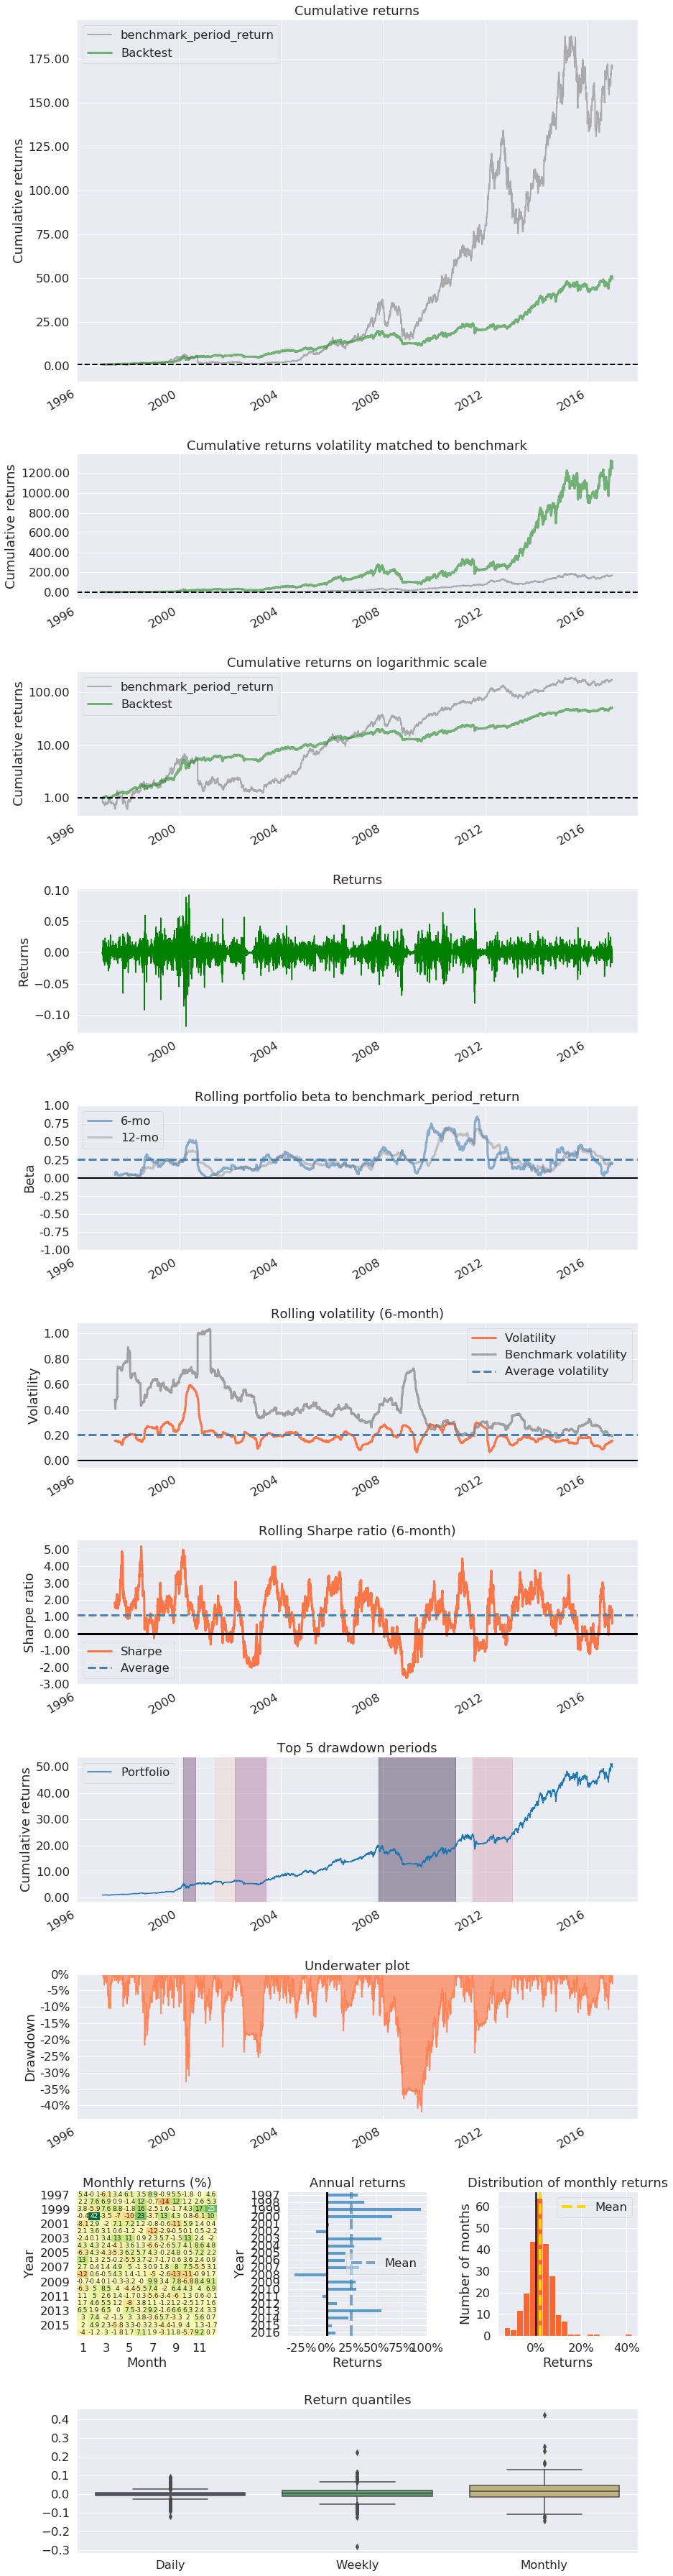

In [21]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']
# Convert benchmark returns to daily returns
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1
pf.create_returns_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)